## Instacart - Clustering
In this notebook I will try creating customer segmentation for Instacart customers according to the purchases made.  Instacart has access to thousands of products, categorized into aisles and departments.  With the large number of features, we will look at using Principal Component Analysis to find new dimensions to make clustering easier.  

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set(style='whitegrid')

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler

import random

In [4]:
orders = pd.read_csv('../data/raw/orders.csv')
products = pd.read_csv('../data/raw/products.csv')
order_details_prior = pd.read_csv('../data/raw/order_products__prior.csv')
#order_details_train = pd.read_csv('../data/raw/order_products__train.csv')


The amount of data required for processing is too large for my laptop to crunch.  We will need to reduce the number of users in our analysis.  How many users do we have?

In [5]:
len(orders.user_id.unique())

206209

There are over 200,000 unique users.  I will reduce this number to 20,000. 

In [7]:
# create a set of users
unique_users = set(orders.user_id.unique())

# randomly sample 20,000 users
selected_users = random.sample(unique_users, 20000)

In [8]:
# select orders related to our selected users
orders_subset = orders[orders.user_id.isin(selected_users)]

Next, we find the purchase history for each user - simply put, an entry for each time a user has purchased a product throughout the order history.  It is possible to for a user to purchase a product more than once. 

In [9]:
# we simplify the purchase history to only include user_id & product_id
purchase_history = pd.merge(orders_subset, 
                            order_details_prior, 
                            on=['order_id'])[['user_id', 'product_id']]

In [12]:
# how many unique products do we have listed in this purchase history? 
len(purchase_history.product_id.unique())

41256

In [13]:
# how many unique products are available for purchase?
len(products)

49688

There are about 50,000 unique products in the Instacart dataset.  For our reduced user dataset, the number of unique products has been brought down to ~41,260.  

I want to create a purchase history matrix that contains user_ids on the left, and each product as a column.  The center cells will display how many times a user has purchased a product.  We will accomplish creating this matrix using the pandas crosstab feature. 

In [14]:
crosstab = pd.crosstab(index=purchase_history.user_id, columns=purchase_history.product_id)

In [15]:
crosstab.shape

(20000, 41256)

The crosstab now contains a summarized purchase history for our selected users.  At the moment, this data represents a 28000 X 41256 matrix. 

We do not want to perform a cluster analysis on this data as is - what would be helpful is a dimensionality reduction prior to processing.  Prior to moving onto dimensionality reduction, I am going to scale our dataset. 

In [17]:
# create scaler
sc = StandardScaler()

# scale crosstab data
crosstab_scaled = sc.fit_transform(crosstab)

In [38]:
crosstab_scaled.shape

(20000, 41256)

# Dimensionality Reduction
Dimensionality reduction will be completed using Principal Component Analysis (PCA).  The aim here is to reduce the number of features while retaining the greatest explained varaince as possible. 

In [39]:
# create PCA
pca_full = PCA()

# fit oru data
pca_full.fit(crosstab_scaled) ## note: This takes 1:20 minutes to complete 20,000 records

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

With the PCA fitted, we can now look to see the amount of variance that is explained with respect to the number of components used.

In [46]:
# find cumulative sum of explained variance
ev_cumsum = pca_full.explained_variance_ratio_.cumsum()

# find out how many components we need to expain different levels of variance
for i in np.arange(0.5, 0.9, 0.05):
    print('{0:.2f}: {1:}'.format(i, np.sum(ev_cumsum <= i)))
    
for i in np.arange(0.9, 1.01, 0.01):
    print('{0:.2f}: {1:}'.format(i, np.sum(ev_cumsum <= i)))

0.50: 1881
0.55: 2258
0.60: 2688
0.65: 3183
0.70: 3758
0.75: 4438
0.80: 5260
0.85: 6282
0.90: 7631
0.91: 7959
0.92: 8313
0.93: 8697
0.94: 9117
0.95: 9592
0.96: 10150
0.97: 10830
0.98: 11710
0.99: 13029
1.00: 19147


Let's graph these results to gain perspective on the results.

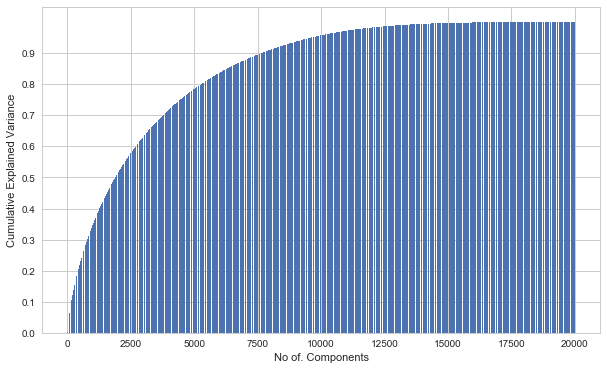

In [49]:
# Create a plot to find out how our components explain our data
y = pca.explained_variance_ratio_.cumsum()
x = np.arange(len(y))

# create plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot
plt.bar(x, y)

# set labels
plt.xlabel('No of. Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance for Instacart Purchase History')
plt.yticks(np.arange(0, 1, 0.1))

#plt.savefig()
plt.show()

Reviewing the above data, I believe we recieve diminishing returns after the 98% threshold.  We can achieve 98% explained variance using 11,710 componets.  Gaining an extra percentage of explained variance to achieve 98% requires an additional ~1,300 components. 

To push forward, we create a new PCA using our desired componets of 11,710.

In [51]:
# create pca to explain 98% of data
pca = PCA(n_components=11710)

# fit our scaled data
pca.fit(crosstab_scaled)

PCA(copy=True, iterated_power='auto', n_components=11710, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [56]:
# transform the data
crosstab_transformed = pca.transform(crosstab_scaled)

In [31]:
#from sklearn.externals import joblib

# save our pca classifier
#joblib.dump(pca, '../models/pca_20kinput_11710comp.pkl')

# Cluster Algoritms
With our PCA components identified, we begin clustering algorithms.  We will look at:
* KMeans
* DBScan
* Hierarchiacal Cluster

## KMeans

KMeans is fairly straight forward - however we need to determine the appropriate amount of clusters to be used for our algorithm.  

We will determine 'k' using the output of 3 methods
1. Elbow Method
2. Silhouette Coefficient
3. Calinski-Harabaz Index

### Elbow Method
For the Elbow Method, we compute K-Means partitions for many values of **k** and plot the inertia as it relates to the number of clusters.  The ideal value of **k** is one that corresponds to an elbow in the curve, after which adding more clusters is considered to offer diminishing returns.  

Inertia will always decrease to zero for **k = n**, where n is the number of observations.  

### Silhouette Coefficient
The silhouette coefficient measures how close each point in one cluster is to points in the neighboring clusters.  This score varies from -1 to 1.   measure has a range of [-1, 1].  

Scores near 1 show that the samples are far away from the neighboring clusters.  scores of 0 indicate that samples overlap or are very close to the decision boundary between enighbouring clusters.  Negative values indicate that samples might have been assigned to the wrong cluster. 

### Calinski-Harabaz Index
Calinski-Harabaz compares between-cluster dispersion to the within-cluster dispersion.  The higher the score, the more dense and well separated our clusters appear to be. 


In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabaz_score

In order to calculate each of the above metric for various values of K, I've created the below function: kmeans_performance_metrics.

It simply takes a dataset and an upper limit of k to use for clustering.  We calculate kmeans at each value of k, along with each metric, returning the results. 

In [54]:
def kmeans_performance_metrics(data, nCluster):
    '''
        Compute K-Means partitions for values of K, ranging from 
        2 to nCluster+1.  The inertia for each partition is recorded
        and returned as an array
        
        Params
        ------
        data: The dataset to perform KMeans clustering
        
        nCluster: The number of partitions to create
    '''
    
    # create an array to hold our results
    inertias = []
    silhouette_scores = []
    calinski_score = []
    
    # Process each range
    for i in range(2, nCluster+1):
        print('processing k={}'.format(i))
        
        # build model
        model = KMeans(n_clusters=i, init='k-means++',random_state=42).fit(data)
        
        # determine scores
        inertias.append(model.inertia_)
        silhouette_scores.append(silhouette_score(data, model.labels_))
        calinski_score.append(calinski_harabaz_score(data, model.labels_))
    
    return inertias, silhouette_scores, calinski_score

We will loop through k=2 to 15

In [58]:
# define how many clusters we want to test
kRange=15

# find the inertias related to each cluster size
inertias, silhouette_scores, calinski_score = kmeans_performance_metrics(crosstab_transformed, kRange)

processing k=2
processing k=3
processing k=4
processing k=5
processing k=6
processing k=7
processing k=8
processing k=9
processing k=10
processing k=11
processing k=12
processing k=13
processing k=14
processing k=15


### Inertia Results
Plotting the results for intertia, we find that we do not have a smooth sloping graph that one would hope for.  Based on the results, we see a large dip at k=3 - This seems odd, but I'll remember this when evaluating other metrics.  If I were to look for the elbow in this graph, I'd most likely select k=14.  

I'm not certain on what value of k to be selected at this point, so lets move onto the other metrics to verify. 

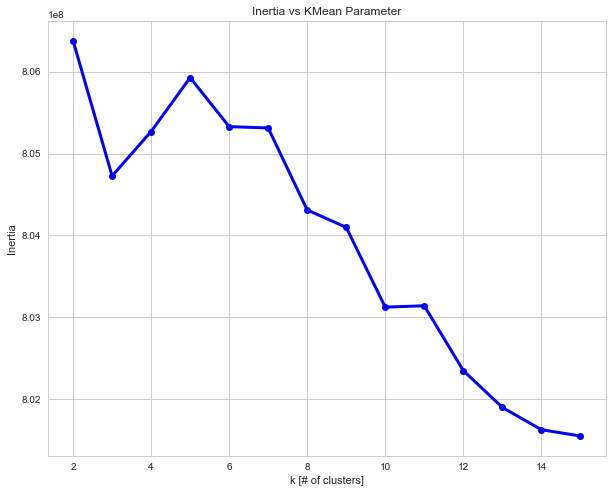

In [59]:
# Plot our results
fig, ax = plt.subplots(figsize=(10,8))

# plot results
plt.plot(np.arange(2, kRange+1), inertias, 'o-', color='blue', linewidth=3)

# set labels
plt.xlabel('k [# of clusters]')
plt.ylabel('Inertia')
plt.title('Inertia vs KMean Parameter')

plt.savefig('../reports/figures/kmeans_inertia.png')

plt.show()

### Silhouette Results
We are looking for a k size that maximizes our silhouette coefficient.  When looking at the graph, it's apparent that k=3 is the leaders.  We have additional spikes at k=6, 8, 10. 

Comparing this to the inertia results, k=3 is starting to look like the leading choice.  Let's move on to the final metric.

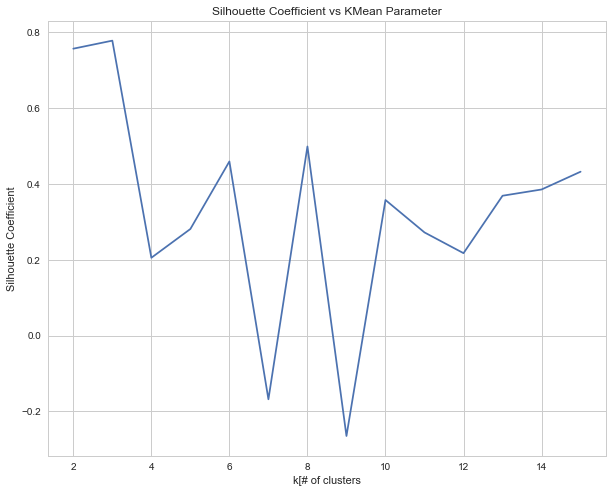

In [60]:
fig, ax = plt.subplots(figsize=(10,8))

# plot silhouette_scores
plt.plot(np.arange(2, kRange+1), silhouette_scores)

# set label
plt.ylabel('Silhouette Coefficient')
plt.xlabel('k[# of clusters')
plt.title('Silhouette Coefficient vs KMean Parameter')

# save
plt.savefig('../reports/figures/silhouette_coefficient.png')

plt.show()

### Calinski-Harabaz Score Results
We are looking for cluster size that maximizes the Calinski-Harabaz score.  Looking at the graph, it is clear that k=3 is the winner.  This is aligned with our results from our prior metrics as well.  Let's proceed forward with k=3.

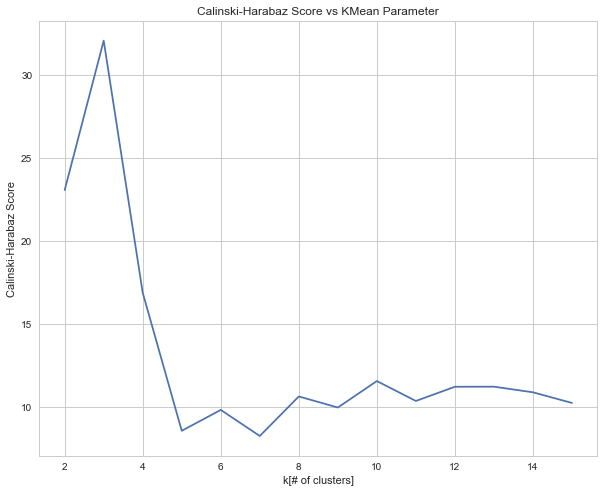

In [61]:
fig, ax = plt.subplots(figsize=(10,8))

# plot calinski_score
plt.plot(np.arange(2, kRange+1), calinski_score)

# set label
plt.ylabel('Calinski-Harabaz Score')
plt.xlabel('k[# of clusters]')
plt.title('Calinski-Harabaz Score vs KMean Parameter')

# save
plt.savefig('../reports/figures/calinski_harabaz_score.png')

plt.show()

## Exploring Customer Segments
We found that the optimal cluster size is 3 for our data.  Based on these clusters, what can be said about the products purchased for each cluster?

In [40]:
# create our kmeans model & predict clusters
kmeans_model = KMeans(n_clusters=3, init='k-means++', random_state=42).fit(crosstab_transformed)
c_pred = kmeans_model.predict(crosstab_transformed)

In [41]:
for c in np.unique(c_pred):
    print('{}: {}'.format(c, np.sum(c_pred==c)))

0: 19998
1: 1
2: 1


In [39]:
# assign the cluster predictions to our customers
cust_clust = crosstab.copy()
cust_clust['cluster'] = c_pred

#cust_clust.head()

Something is wrong with our clusters - we shouldn't have such unevenly structured clusters

## Hierarchical Clustering
We will take a look at hierarchical clustering next.  We will again attempt to review silhouette and Calinski-Harabaz Score results to best find a clustering metric. 


In [42]:
from sklearn.cluster import AgglomerativeClustering

In [44]:
def hierarchical_performance_metrics(data, nCluster):
    '''
        Compute Agglomerative Clustering for various cluster sizes, 
        ranging from 2 to nCluster+1.  The silhouette & calinski harabaz scores
        are calculated for each and returned. 
        
        Params
        ------
        data: The dataset to perform clustering
        
        nCluster: The number of partitions to create
    '''
    
    # create an array to hold our results
    silhouette_scores = []
    calinski_score = []
    
    # Process each range
    for i in range(2, nCluster+1):
        print('processing clusters={}'.format(i))
        
        # build model
        model = AgglomerativeClustering(linkage='ward', n_clusters=i).fit(data)
        
        # determine scores
        silhouette_scores.append(silhouette_score(data, model.labels_))
        calinski_score.append(calinski_harabaz_score(data, model.labels_))
    
    return silhouette_scores, calinski_score

In [ ]:
# define how many clusters we want to test
nClusters=15

# find the inertias related to each cluster size
silhouette_scores, calinski_score = hierarchical_performance_metrics(crosstab_transformed, nClusters)

processing k=2


### Silhouette Results
We are looking for a k size that maximizes our silhouette coefficient.  When looking at the graph, it's apparent that k=3 is the leaders.  We have additional spikes at k=6, 8, 10. 

Comparing this to the inertia results, k=3 is starting to look like the leading choice.  Let's move on to the final metric.

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

# plot silhouette_scores
plt.plot(np.arange(2, kRange+1), silhouette_scores)

# set label
plt.ylabel('Silhouette Coefficient')
plt.xlabel('Cluster Size')
plt.title('Silhouette Coefficient Using Agglomerative Clustering')

# save
plt.savefig('../reports/figures/hc_silhouette_coefficient.png')

plt.show()

### Calinski-Harabaz Score Results
We are looking for cluster size that maximizes the Calinski-Harabaz score.  Looking at the graph, it is clear that k=3 is the winner.  This is aligned with our results from our prior metrics as well.  Let's proceed forward with k=3.

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

# plot calinski_score
plt.plot(np.arange(2, kRange+1), calinski_score)

# set label
plt.ylabel('Calinski-Harabaz Score')
plt.xlabel('Cluster Size')
plt.title('Calinski-Harabaz Score Using Agglomerative Clustering')

# save
plt.savefig('../reports/figures/hc_calinski_harabaz_score.png')

plt.show()

## DBSCAN
TBD